<a href="https://colab.research.google.com/github/LuigiElo/DL-PINNs/blob/main/mainJacob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial version

In [1]:
!pip install datasets
!pip install transformers
!pip install deepxde

In [2]:
# Modules to be loaded and used
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
from torch import nn
import math
from functools import partial
from pathlib import Path
from tqdm import tqdm
import rich
from typing import List, Tuple, Optional, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import transformers
import tokenizers
import datasets
import zipfile
from huggingface_hub import hf_hub_download

from __future__ import division
from __future__ import print_function

import numpy as np
import deepxde as dde
from deepxde.backend import tf
from scipy.integrate import odeint
import re


from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


# (a) Function approximation
## 1D

Compiling model...
Building feed-forward neural network...
'build' took 0.112662 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.416752 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [4.94e-01]    [4.48e-01]    [9.51e-01]    
1000      [4.29e-05]    [3.15e-01]    [7.97e-01]    
2000      [3.38e-06]    [3.93e-01]    [8.90e-01]    
3000      [9.02e-07]    [4.15e-01]    [9.15e-01]    
4000      [8.78e-07]    [4.14e-01]    [9.13e-01]    
5000      [5.04e-07]    [4.06e-01]    [9.05e-01]    
6000      [4.22e-05]    [3.92e-01]    [8.89e-01]    
7000      [8.11e-06]    [3.89e-01]    [8.86e-01]    
8000      [1.46e-04]    [3.71e-01]    [8.65e-01]    
9000      [1.69e-07]    [3.71e-01]    [8.66e-01]    
10000     [4.74e-06]    [3.65e-01]    [8.58e-01]    

Best model at step 9000:
  train loss: 1.69e-07
  test loss: 3.71e-01
  test metric: [8.66e-01]

'train' took 10.115761 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


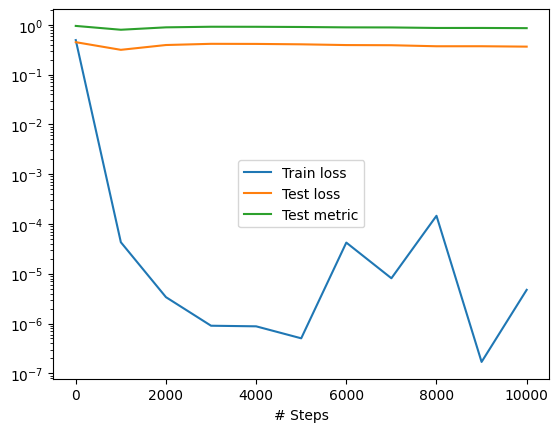

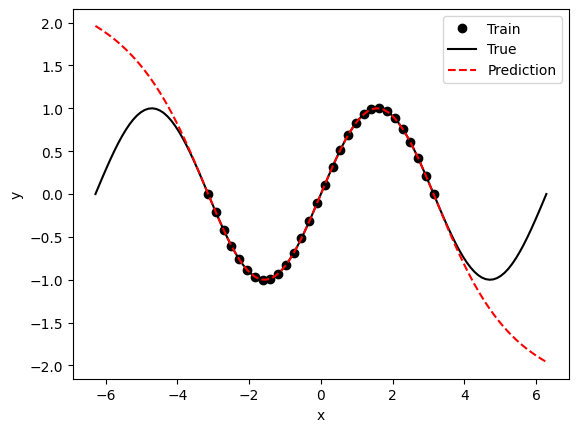

In [3]:
n = 30
a = 1
b = 5
c = 1
N = np.pi
X  = np.linspace(-N,N,n)
#y  = a*X**3 + b*X**2 + c*X
y = np.sin(X)

Xtest = np.linspace(-2*N,2*N,4*n)
#ytest = a*Xtest**3 + b*Xtest**2 + c*Xtest
ytest = np.sin(Xtest)

# function approximation, test outside parameter domain
data1D = dde.data.DataSet(
    X_train=np.reshape(X, (-1, 1)),
    y_train=np.reshape(y, (-1, 1)),
    X_test=np.reshape(Xtest, (-1, 1)),
    y_test=np.reshape(ytest, (-1, 1)),
    col_x=(0,),
    col_y=(1,),
)

layer_size = [1] + 3*[20] + [1]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

model1 = dde.Model(data1D, net)
model1.compile("adam", lr = 0.001, metrics=["l2 relative error"])
losshistory, train_state = model1.train(epochs=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)


## 2D

Compiling model...
Building feed-forward neural network...
'build' took 0.270696 s

'compile' took 0.839755 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [8.36e-01]    [8.92e-01]    [1.34e+00]    
1000      [3.83e-03]    [1.79e-01]    [5.98e-01]    
2000      [1.65e-04]    [2.49e-02]    [2.23e-01]    
3000      [3.42e-05]    [1.32e-02]    [1.63e-01]    
4000      [1.38e-05]    [1.15e-02]    [1.52e-01]    
5000      [9.57e-06]    [1.07e-02]    [1.46e-01]    

Best model at step 5000:
  train loss: 9.57e-06
  test loss: 1.07e-02
  test metric: [1.46e-01]

'train' took 10.512352 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


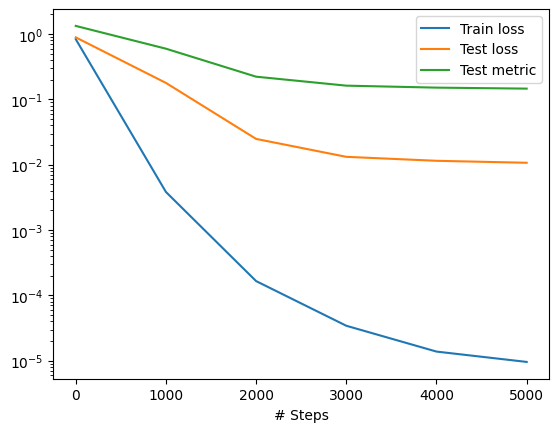

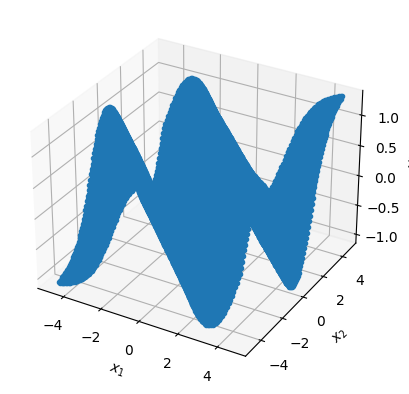

In [4]:
n = 30
N = np.pi

# the function that I'm going to plot
def y_func(X1,X2):
 return np.sin(X1+X2)

x1 = np.linspace(-N,N,n)
x2 = x1

X1,X2 = meshgrid(x1, x2) # grid of point
y = y_func(X1, X2) # evaluation of the function on the grid

x1test = np.linspace(-1.5*N,1.5*N,4*n)
x2test = x1test

X1test,X2test = meshgrid(x1test, x2test) # grid of point
ytest = y_func(X1test, X2test) # evaluation of the function on the grid


# function approximation, test outside parameter domain
data2D = dde.data.DataSet(
    X_train = np.hstack(( np.reshape(X1, (-1, 1)),np.reshape(X2, (-1, 1)) )),
    y_train = np.reshape(y, (-1, 1)),
    X_test = np.hstack(( np.reshape(X1test, (-1, 1)),np.reshape(X2test, (-1, 1)) )),
    y_test = np.reshape(ytest, (-1, 1)),
    col_x = (0,),
    col_y = (1,),
)

layer_size = [2] + [20] * 3 + [1]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

model2 = dde.Model(data2D, net)
model2.compile("adam", lr = 0.001, metrics=["l2 relative error"])
losshistory, train_state = model2.train(epochs=5000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)


# (b)

## 1D

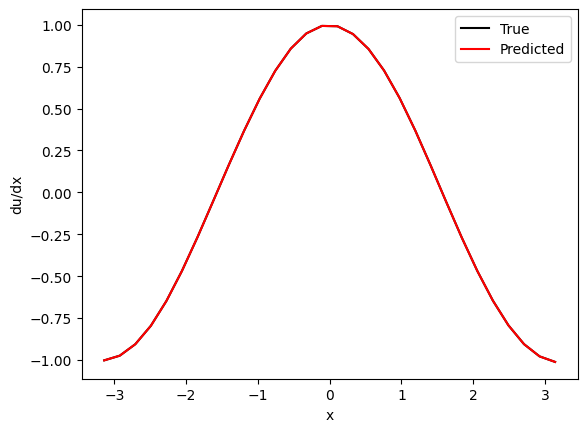

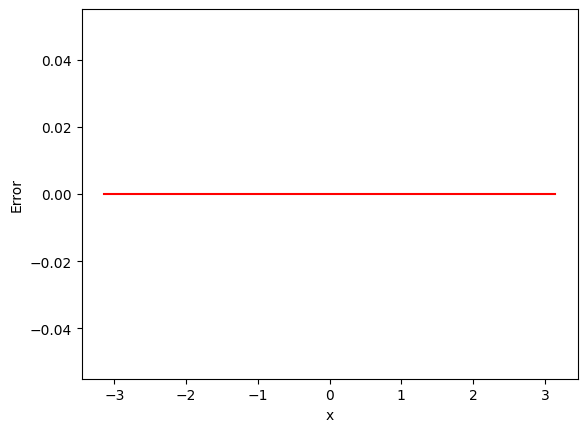

In [5]:
# compute gradient of solution
def dudx(x, u):
  return dde.grad.jacobian(u, x, i=0)

du_dx = model1.predict(np.reshape(X, (-1, 1)), operator=dudx)

yx = du_dx

plt.figure()
plt.plot(X,yx,'k',label='True')
plt.plot(np.reshape(X, (-1, 1)),du_dx,'r',label='Predicted')
plt.xlabel('x')
plt.ylabel('du/dx')
plt.legend()
plt.show()

plt.figure()
plt.plot(X,du_dx-np.reshape(yx,(-1,1)),'r')
plt.xlabel('x')
plt.ylabel('Error')
plt.show()

# (c)

## 1D

Compiling model...
Building feed-forward neural network...
'build' took 0.174441 s

'compile' took 0.710596 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.80e+00]    [1.29e+00]    [1.61e+00]    
1000      [3.07e-03]    [6.12e-01]    [1.11e+00]    
2000      [3.27e-04]    [5.74e-01]    [1.07e+00]    
3000      [8.05e-05]    [5.04e-01]    [1.00e+00]    
4000      [2.78e-05]    [4.54e-01]    [9.53e-01]    
5000      [9.77e-06]    [4.16e-01]    [9.12e-01]    

Best model at step 5000:
  train loss: 9.77e-06
  test loss: 4.16e-01
  test metric: [9.12e-01]

'train' took 4.346720 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


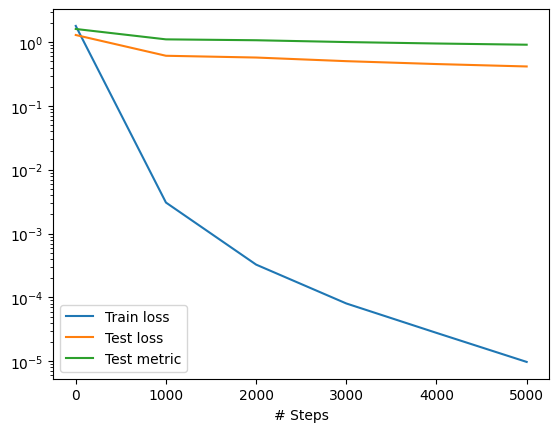

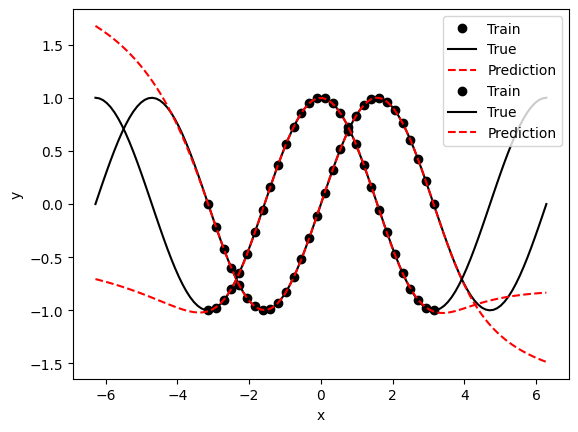

In [6]:
n = 30
X  = np.linspace(-np.pi,np.pi,n)
y  = [np.sin(X),np.cos(X)]

Xtest  = np.linspace(-2*np.pi,2*np.pi,4*n)
ytest  = [np.sin(Xtest),np.cos(Xtest)]

# reshaping output training data
y1 = np.asmatrix(y[0]).transpose()
y2 = np.asmatrix(y[1]).transpose()
ynew = np.concatenate((y1,y2),axis=1)
ynew = np.asarray(ynew)

# reshaping output test data
ytest1 = np.asmatrix(ytest[0]).transpose()
ytest2 = np.asmatrix(ytest[1]).transpose()
ytestnew = np.concatenate((ytest1,ytest2),axis=1)
ytestnew = np.asarray(ytestnew)


# function approximation, test outside parameter domain
data1Dg = dde.data.DataSet(
    X_train=np.reshape(X, (-1, 1)),
    y_train=ynew,
    X_test=np.reshape(Xtest, (-1, 1)),
    y_test=ytestnew,
    col_x=(0,),
    col_y=(1,),
)

layer_size = [1] + [20] * 3 + [2]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data1Dg, net)
model.compile("adam", lr = 0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=5000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

## 2D

Compiling model...
Building feed-forward neural network...
'build' took 0.068427 s

'compile' took 0.275554 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.73e-01]    [5.82e-01]    [1.08e+00]    
1000      [9.43e-04]    [5.28e-01]    [1.03e+00]    
2000      [1.55e-04]    [4.89e-01]    [9.89e-01]    
3000      [6.40e-05]    [4.79e-01]    [9.78e-01]    
4000      [4.25e-05]    [4.67e-01]    [9.66e-01]    
5000      [3.06e-05]    [4.52e-01]    [9.51e-01]    

Best model at step 5000:
  train loss: 3.06e-05
  test loss: 4.52e-01
  test metric: [9.51e-01]

'train' took 6.532557 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


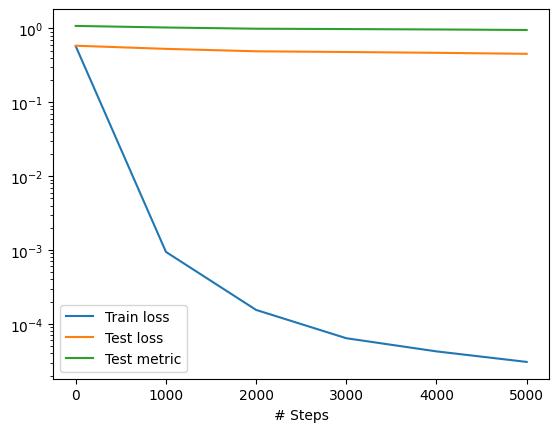

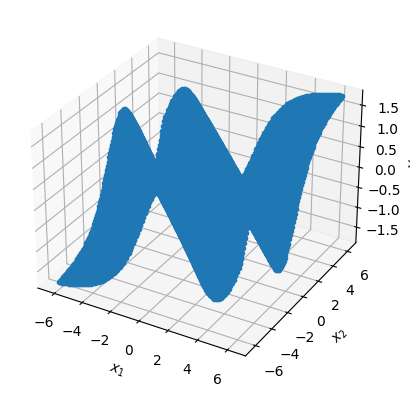

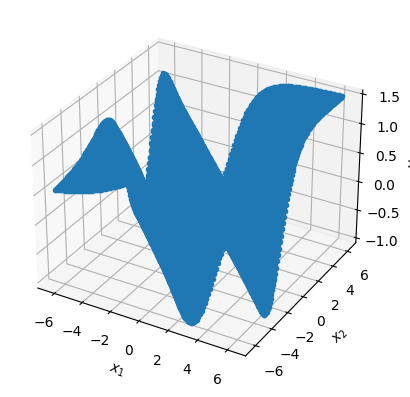

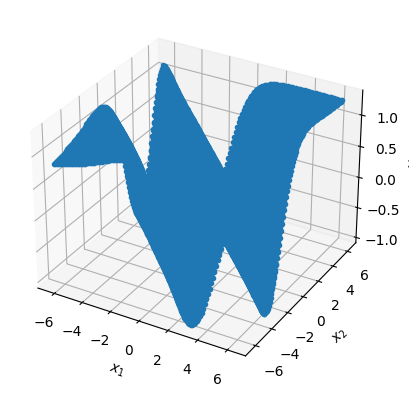

In [7]:
n = 30
N = np.pi

# the function that I'm going to plot
def y_func(X1,X2):
 return np.sin(X1+X2)

def y_grad(X1,X2):
 return np.cos(X1+X2),np.cos(X1+X2)

x1 = np.linspace(-N,N,n)
x2 = x1

X1,X2 = meshgrid(x1, x2) # grid of points
y = y_func(X1, X2) # evaluation of the function on the grid
yg = y_grad(X1,X2) # evaluation of the gradient on the grid

# Collecting and reshaping training function val and gradient val into one output:
y = np.hstack((np.reshape(y, (-1, 1)), np.reshape(yg[0], (-1, 1)), np.reshape(yg[1], (-1, 1)) ))


x1test = np.linspace(-2*N,2*N,4*n)
x2test = x1test

X1test,X2test = meshgrid(x1test, x2test) # grid of point
ytest = y_func(X1test, X2test) # evaluation of the function on the grid
ytestg = y_grad(X1test,X2test) # evaluation of the gradient on the grid

# Collecting and reshaping testing output function val and gradient val into one output:
ytest = np.hstack((np.reshape(ytest, (-1, 1)), np.reshape(ytestg[0], (-1, 1)), np.reshape(ytestg[1], (-1, 1)) ))




# function approximation, test outside parameter domain
data2Dg = dde.data.DataSet(
    X_train = np.hstack(( np.reshape(X1, (-1, 1)),np.reshape(X2, (-1, 1)) )),
    y_train = y,
    X_test = np.hstack(( np.reshape(X1test, (-1, 1)),np.reshape(X2test, (-1, 1)) )),
    y_test = ytest,
    col_x = (0,),
    col_y = (1,),
)

layer_size = [2] + [20] * 3 + [3]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data2Dg, net)
model.compile("adam", lr = 0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=5000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)